<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/5_CodingDrillDown/Experiments/MNIST_Step%201_BasicSkeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:

- Get the basic skeleton interms of convolution and placement of transition blocks (max pooling, 1x1's)
- Reduce the number of parameters as low as possible
- Add GAP and remove the last BIG kernel.

## Results:
- Parameters: 4572
- Best Training Accuracy: 98.22
- Best Test Accuracy: 98.43

## Analysis:
- We have structured our model in a readable way
- The model is lighter with less number of parameters 
- The performace is reduced compared to previous models. Since we have reduced model capacity, this is expected, the model has capability to learn.   
- Next, we will be tweaking this model further and increase the capacity to push it more towards the desired accuracy.

# Import Libraries

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [15]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [16]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [17]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


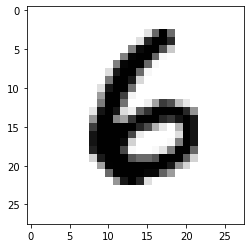

In [18]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

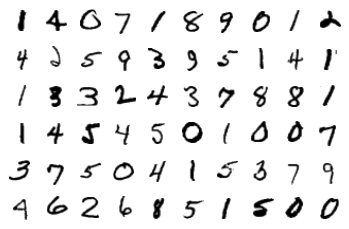

In [19]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [20]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        #Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=0,bias=False),  # 28x28 output 28x28 RF : 3x3
            nn.ReLU(),

            nn.Conv2d(8, 16, 3,padding=0,bias=False), # 28x28 output 28x28 RF : 5x5
            nn.ReLU(),

                    
        )

        #Transition Block (MaxPool + 1x1)
        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            # 1x1 convolution
            nn.Conv2d(16, 8, 1,bias=False), # 26x26 output - 26x26 RF 14x14
            nn.ReLU(),

            # 26x26 output - 13x13 RF 14x14

        )

        #Block 2
        self.conv2 =  nn.Sequential(

            nn.Conv2d(8, 10, 3,padding=0, bias=False), # 13x13 output - 11x11 RF 16x16
            nn.ReLU(),

            nn.Conv2d(10, 10, 3,padding=0, bias=False),  # 11x11 output - 9x9 RF 18x18
            nn.ReLU(),

            nn.Conv2d(10, 16, 3,padding=0, bias=False), # 9x9 output - 7x7 RF 20x20
            nn.ReLU(),
          
        )

        #outputblock

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)

        )  
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool2d(x)
        x = x.view(-1,10)

        return F.log_softmax(x,dim=1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [21]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]             128
              ReLU-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 10, 10, 10]             720
              ReLU-9           [-1, 10, 10, 10]               0
           Conv2d-10             [-1, 10, 8, 8]             900
             ReLU-11             [-1, 10, 8, 8]               0
           Conv2d-12             [-1, 16, 6, 6]           1,440
             ReLU-13             [-1, 16, 6, 6]               0
           Conv2d-14             [

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [22]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [23]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=2.3022994995117188 Batch_id=468 Accuracy=10.91: 100%|██████████| 469/469 [00:09<00:00, 47.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3024, Accuracy: 1285/10000 (12.85%)

EPOCH: 2


Loss=2.298260450363159 Batch_id=468 Accuracy=13.30: 100%|██████████| 469/469 [00:09<00:00, 47.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2999, Accuracy: 1535/10000 (15.35%)

EPOCH: 3


Loss=0.1952918916940689 Batch_id=468 Accuracy=53.12: 100%|██████████| 469/469 [00:10<00:00, 46.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3241, Accuracy: 8990/10000 (89.90%)

EPOCH: 4


Loss=0.11374709010124207 Batch_id=468 Accuracy=93.53: 100%|██████████| 469/469 [00:09<00:00, 47.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1381, Accuracy: 9552/10000 (95.52%)

EPOCH: 5


Loss=0.06849484890699387 Batch_id=468 Accuracy=95.35: 100%|██████████| 469/469 [00:09<00:00, 47.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1099, Accuracy: 9679/10000 (96.79%)

EPOCH: 6


Loss=0.2110450267791748 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:09<00:00, 47.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1219, Accuracy: 9601/10000 (96.01%)

EPOCH: 7


Loss=0.0304917823523283 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:09<00:00, 47.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0766, Accuracy: 9779/10000 (97.79%)

EPOCH: 8


Loss=0.028312278911471367 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:09<00:00, 47.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 9783/10000 (97.83%)

EPOCH: 9


Loss=0.08492278307676315 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:09<00:00, 46.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9794/10000 (97.94%)

EPOCH: 10


Loss=0.014665485359728336 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:09<00:00, 47.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9752/10000 (97.52%)

EPOCH: 11


Loss=0.11783042550086975 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:09<00:00, 46.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9805/10000 (98.05%)

EPOCH: 12


Loss=0.1054205521941185 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:10<00:00, 46.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9822/10000 (98.22%)

EPOCH: 13


Loss=0.019081752747297287 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:10<00:00, 46.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9826/10000 (98.26%)

EPOCH: 14


Loss=0.07138057798147202 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:10<00:00, 46.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0652, Accuracy: 9808/10000 (98.08%)

EPOCH: 15


Loss=0.04443487897515297 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:10<00:00, 46.45it/s]



Test set: Average loss: 0.0526, Accuracy: 9843/10000 (98.43%)



Text(0.5, 1.0, 'Test Accuracy')

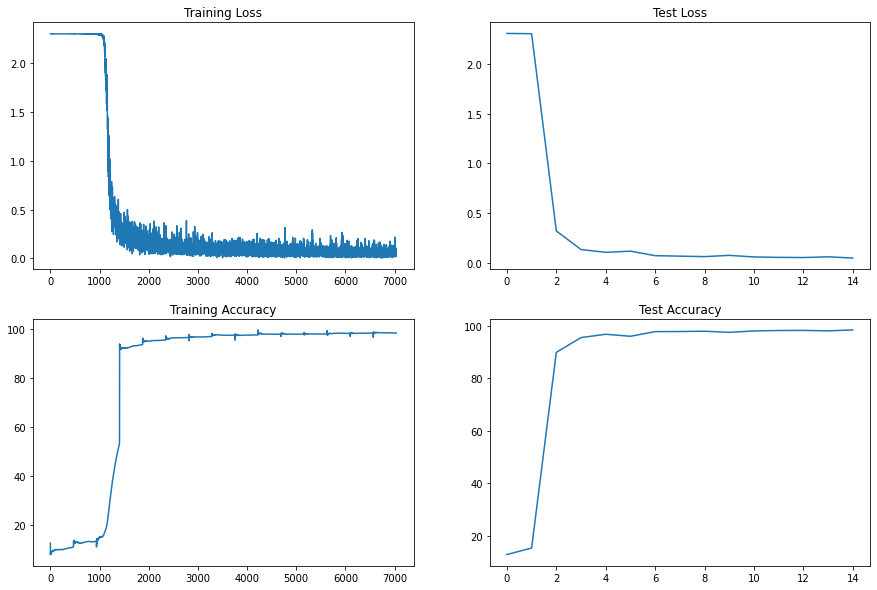

In [24]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")